In [1]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcdefaults()
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['text.color'] = '#909090'
mpl.rcParams['axes.labelcolor']= '#909090'
mpl.rcParams['xtick.color'] = '#909090'
mpl.rcParams['ytick.color'] = '#909090'
mpl.rcParams['font.size'] = 18
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 14

from scipy.stats import pearsonr

In [2]:
snapshot_mean = np.load('../TMP_P0_L1_GLC0_Mean.npy')
pod_modes = np.load('../TMP_P0_L1_GLC0_Modes.npy')[:,:20]

# true
training_snapshots = np.load('../TMP_P0_L1_GLC0.npy')[:7*365]
testing_snapshots = np.load('../TMP_P0_L1_GLC0.npy')[7*365:]

# Projected
trunc_true = np.load('../TMP_P0_L1_GLC0_Coefficients.npy')[:20,7*365:9*365]

# Predicted
trunc_pred = np.load('./RKHS_Test_Prediction.npy')[:20,:2*365]

# Grid info
lats = np.load('../lats.npy')
lons = np.load('../lons.npy')
mask = np.load('../land_mask.npy')

In [3]:
#-------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------
# Visualize DayMet dataset
#-------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------
def visualize_predictions_pod(cf_pred,cf_true,sm,phi):

    #Visualization of state predictions for 4 modes
    
    mode_list = [1,2,3,4,16,17,18,19]
    for mode_num in mode_list:
        fig,ax = plt.subplots(nrows=1)
        ax.plot(cf_true[mode_num,:],label='Truth')
        ax.plot(cf_pred[mode_num,:],label='Prediction')
        
        if mode_num == 0:
            plt.legend(loc='lower left')
        
        plt.title('Forecast')
        plt.xlabel('Test Days')
        plt.ylabel('Magnitude')
        plt.tight_layout()
        plt.savefig('Lineplot_Mode_'+str(mode_num)+'.png')
        plt.show()
   
    dim_0 = cf_pred.shape[-1] #np.shape(snapshots)[0]
    dim_1 = 428 
    dim_2 = 614 

    # Reconstruct
    prediction = sm.flatten()+np.transpose(np.matmul(phi,cf_pred))
    true_pod = sm.flatten()+np.transpose(np.matmul(phi,cf_true))

    true_pod = true_pod.reshape(dim_0,dim_1,dim_2)
    prediction = prediction.reshape(dim_0,dim_1,dim_2)
    
    return true_pod, prediction

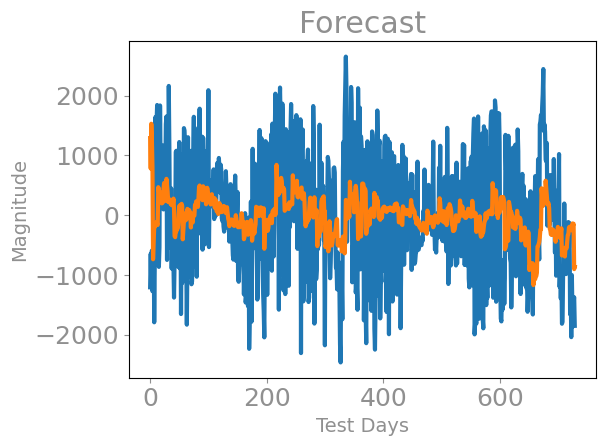

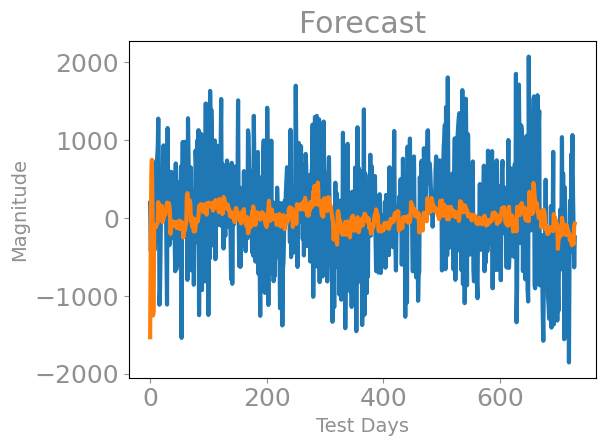

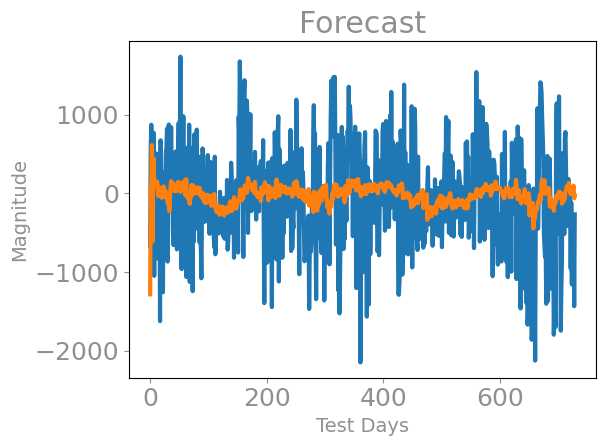

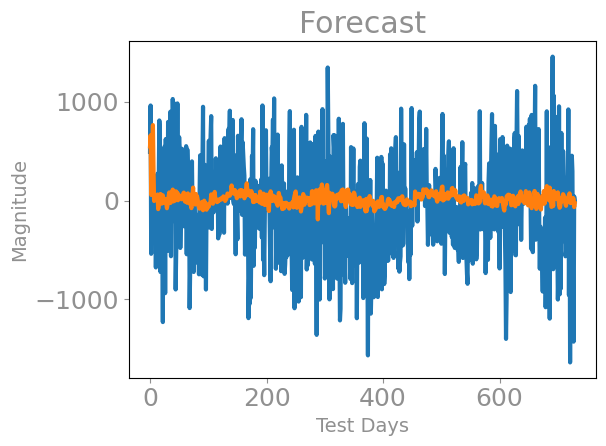

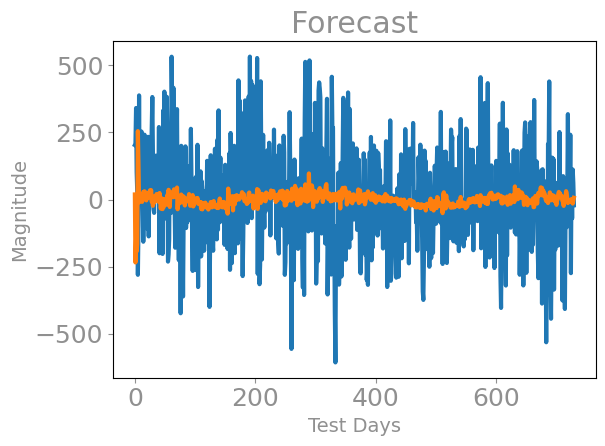

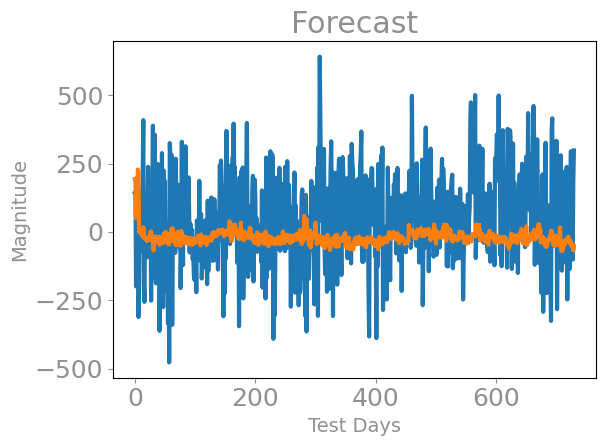

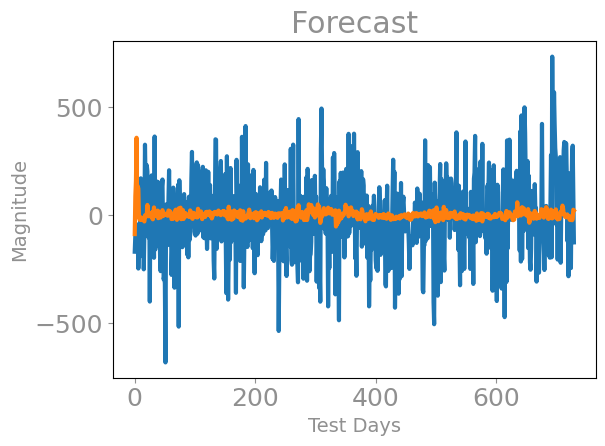

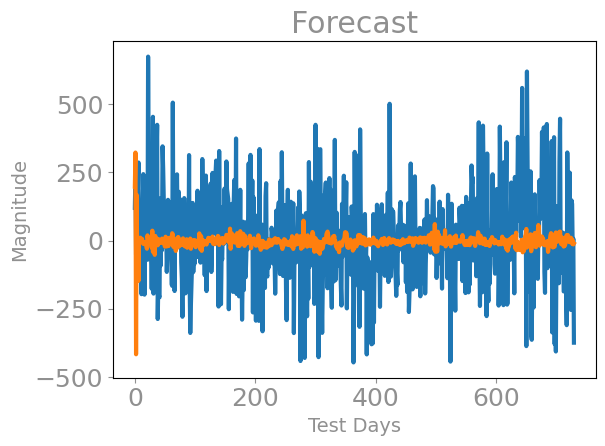

In [35]:
snapshots_pod, snapshots_pred = visualize_predictions_pod(trunc_pred,trunc_true,snapshot_mean,pod_modes)

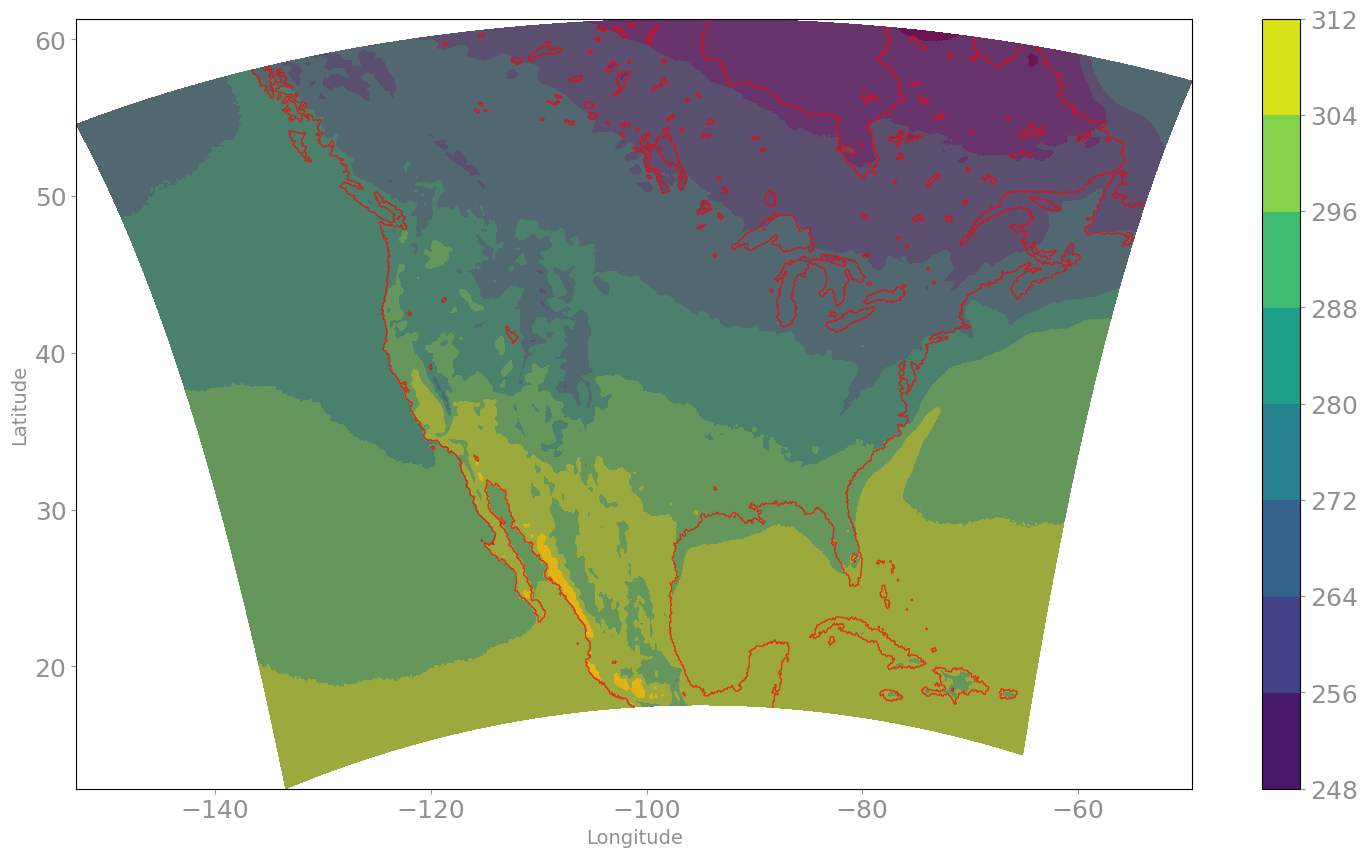

In [5]:
plt.figure(figsize=(18,10))
plt.contourf(lons,lats,snapshots_pred[-1,:,:])
plt.colorbar()
plt.contourf(lons,lats,mask,alpha=0.2,colors=['red'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [6]:
# Load climatology baseline
climatology = np.zeros(shape=(365,np.shape(training_snapshots)[1],np.shape(training_snapshots)[2]))
for year in range(7):
    climatology = climatology+training_snapshots[year*365:(year+1)*365]
climatology = climatology/7.0

# Load persistence baseline
persistence_snapshots = testing_snapshots[0:-7]
persistence_snapshots = np.concatenate((training_snapshots[-14:-7],persistence_snapshots),axis=0)

In [61]:
def lat_lon_func(i,j):
    print('Latitude:',lats[i,j])
    print('Longitude:',lons[i,j])

from scipy import spatial

def probe_func(x,y,loc_name):
    
    print('Longitude:',lons[x,y])
    print('Latitude:',lats[x,y])
    
    plt.figure(figsize=(18,10))
    plt.contourf(lons,lats,testing_snapshots[0,:,:])
    plt.scatter(lons[x,y],lats[x,y],color='orange',label='Probe Location')
    plt.colorbar()
    plt.contour(lons,lats,mask,alpha=0.2,colors=['red'])
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()
        
    for year in range(2):
        fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(22,7))
        
        ax[0].plot(snapshots_pred[year*365:(year+1)*365,x,y],label='Predicted')
        ax[0].plot(testing_snapshots[year*365:(year+1)*365,x,y],label='True')
        
        ax[1].plot(climatology[:,x,y],label='Climatology')
        ax[1].plot(testing_snapshots[year*365:(year+1)*365,x,y],label='True')
        
        ax[2].plot(persistence_snapshots[year*365:(year+1)*365,x,y],label='Persistence')
        ax[2].plot(testing_snapshots[year*365:(year+1)*365,x,y],label='True')
        
        ax[0].set_ylabel('Temperature (Kelvin)')
        ax[0].set_xlabel('Days in testing range')
        ax[1].set_xlabel('Days in testing range')
        ax[2].set_xlabel('Days in testing range')
        
        ax[0].legend()
        ax[1].legend()
        ax[2].legend()
        
        fig.suptitle('Year '+str(year)+' forecast')
        plt.tight_layout()
        fig.subplots_adjust(top=0.88)
        plt.show()
        
        
        fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(22,7))
        
        ax[0].plot(testing_snapshots[year*365:(year+1)*365,x,y]-snapshots_pred[year*365:(year+1)*365,x,y],label='Predicted bias')       
        ax[1].plot(testing_snapshots[year*365:(year+1)*365,x,y]-climatology[:,x,y],label='Climatology bias')
        ax[2].plot(testing_snapshots[year*365:(year+1)*365,x,y]-persistence_snapshots[year*365:(year+1)*365,x,y],label='Persistence bias')
        
        ax[0].set_ylabel('Temperature (Kelvin)')
        ax[0].set_xlabel('Days in testing range')
        ax[1].set_xlabel('Days in testing range')
        ax[2].set_xlabel('Days in testing range')
        
        ax[0].legend()
        ax[1].legend()
        ax[2].legend()
        
        fig.suptitle('Year '+str(year)+' forecast')
        plt.tight_layout()
        fig.subplots_adjust(top=0.88)
        plt.show()

    year = 0    
    bias_preds = np.abs(testing_snapshots[year*365:(year+1)*365,x,y]-snapshots_pred[year*365:(year+1)*365,x,y])
    bias_pers = np.abs(testing_snapshots[year*365:(year+1)*365,x,y]-persistence_snapshots[year*365:(year+1)*365,x,y])
    bias_clim = np.abs(climatology[:,x,y]-testing_snapshots[year*365:(year+1)*365,x,y])

    for year in range(1,2):
        bias_preds_temp = np.abs(testing_snapshots[year*365:(year+1)*365,x,y]-snapshots_pred[year*365:(year+1)*365,x,y])
        bias_clim_temp = np.abs(climatology[:,x,y]-testing_snapshots[year*365:(year+1)*365,x,y])
        bias_pers_temp = np.abs(testing_snapshots[year*365:(year+1)*365,x,y]-persistence_snapshots[year*365:(year+1)*365,x,y])
        
        bias_preds = np.concatenate((bias_preds,bias_preds_temp))
        bias_clim = np.concatenate((bias_clim,bias_clim_temp))
        bias_pers = np.concatenate((bias_pers,bias_pers_temp))

    plt.figure()
    plt.hist(np.hstack(bias_preds),label='Predicted',bins=20,alpha=0.5)
    plt.hist(np.hstack(bias_clim),label='Climatology',bins=20,alpha=0.5)
    plt.hist(np.hstack(bias_pers),label='Persistence',bins=20,alpha=0.5)
    plt.legend()
    plt.ylabel('Instances')
    plt.xlabel('Bias magnitude')
    plt.title('Bias densities')
    plt.show()
    
def cosine_plot(year,int_start,int_end):
    # Finding the cosine similarity
    pred_vals = snapshots_pred[year*365+int_start:year*365+int_end].reshape(int_end-int_start,-1)-273
    pers_vals = persistence_snapshots[year*365+int_start:year*365+int_end].reshape(int_end-int_start,-1)-273
    clim_vals = climatology[int_start:int_end].reshape(int_end-int_start,-1)-273
    true_vals = testing_snapshots[year*365+int_start:year*365+int_end].reshape(int_end-int_start,-1)-273
    
    # For the provided prediction
    pred_cos_vals = np.zeros(shape=(1,pred_vals.shape[-1]))
    pers_cos_vals = np.zeros(shape=(1,pers_vals.shape[-1]))
        
    for location in range(true_vals.shape[-1]):
        pred_cos_vals[0,location] = 1-spatial.distance.cosine(pred_vals[:,location],true_vals[:,location])
        pers_cos_vals[0,location] = 1-spatial.distance.cosine(pers_vals[:,location],true_vals[:,location])
        
    # For Climatology
    clim_cos_vals = np.zeros(shape=(1,clim_vals.shape[-1]))        
    for location in range(true_vals.shape[-1]):
        clim_cos_vals[0,location] = 1-spatial.distance.cosine(clim_vals[:,location],true_vals[:,location])
            
    return pred_cos_vals.reshape(428,614), pers_cos_vals.reshape(428,614), clim_cos_vals.reshape(428,614)
    
def correlation_plot(year,int_start,int_end):
    # Finding the Pearson correlation (without time lag)    
    pred_vals = snapshots_pred[year*365+int_start:year*365+int_end].reshape(int_end-int_start,-1)
    pers_vals = persistence_snapshots[year*365+int_start:year*365+int_end].reshape(int_end-int_start,-1)
    clim_vals = climatology[int_start:int_end].reshape(int_end-int_start,-1)
    true_vals = testing_snapshots[year*365+int_start:year*365+int_end].reshape(int_end-int_start,-1)
    
    # For the provided prediction
    pred_r_vals = np.zeros(shape=(1,pred_vals.shape[-1]))
    pers_r_vals = np.zeros(shape=(1,pers_vals.shape[-1]))
        
    for location in range(true_vals.shape[-1]):
        pred_r_vals[0,location], _ = pearsonr(pred_vals[:,location],true_vals[:,location])
        pers_r_vals[0,location], _ = pearsonr(pers_vals[:,location],true_vals[:,location])
           
    # For Climatology
    clim_r_vals = np.zeros(shape=(1,clim_vals.shape[-1]))        
    for location in range(true_vals.shape[-1]):
        clim_r_vals[0,location], _ = pearsonr(clim_vals[:,location],true_vals[:,location])
            
    return pred_r_vals.reshape(428,614), pers_r_vals.reshape(428,614), clim_r_vals.reshape(428,614)

In [62]:
lat_lon_func(220,400)

Latitude: 41.23972
Longitude: -87.54488


Longitude: -87.54488
Latitude: 41.23972


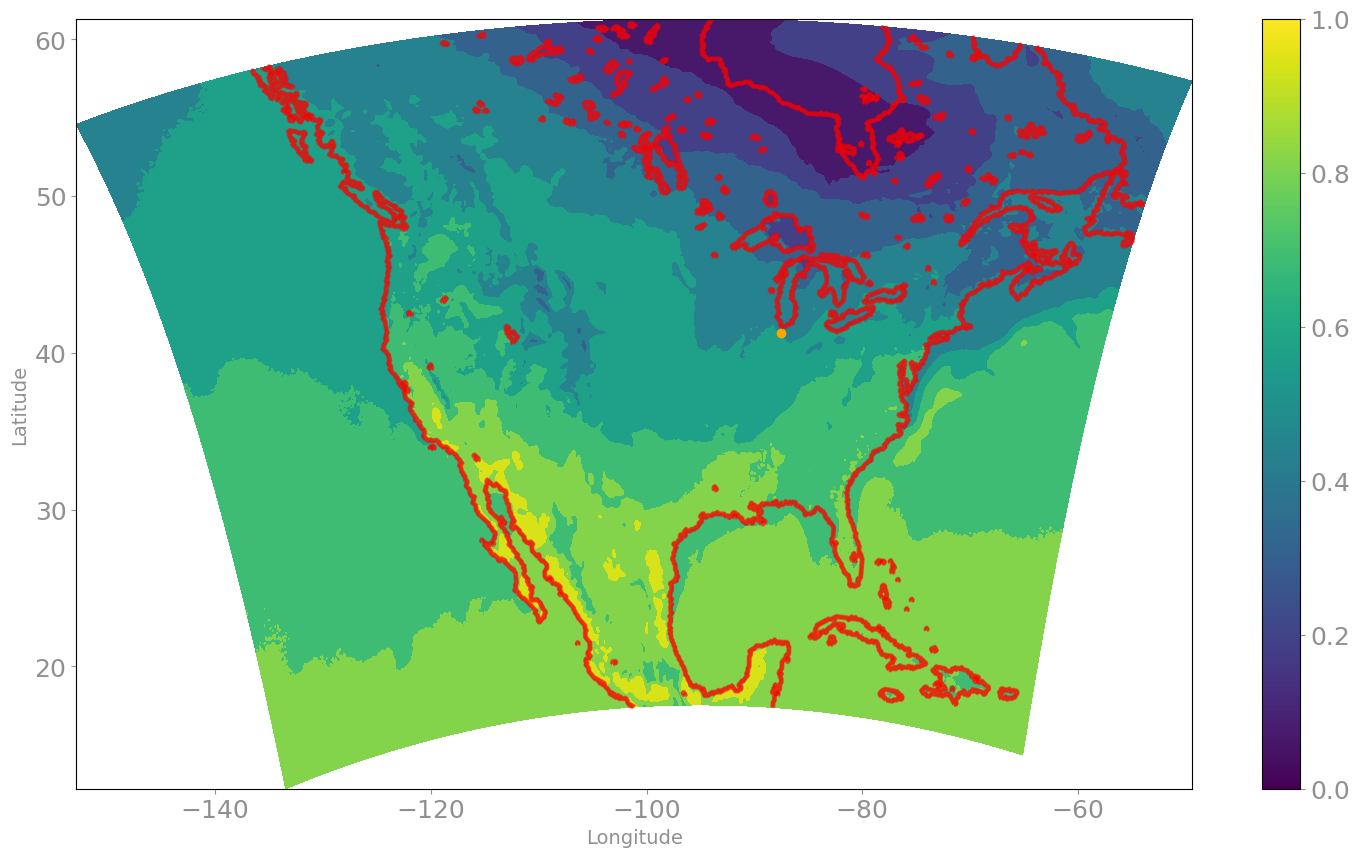

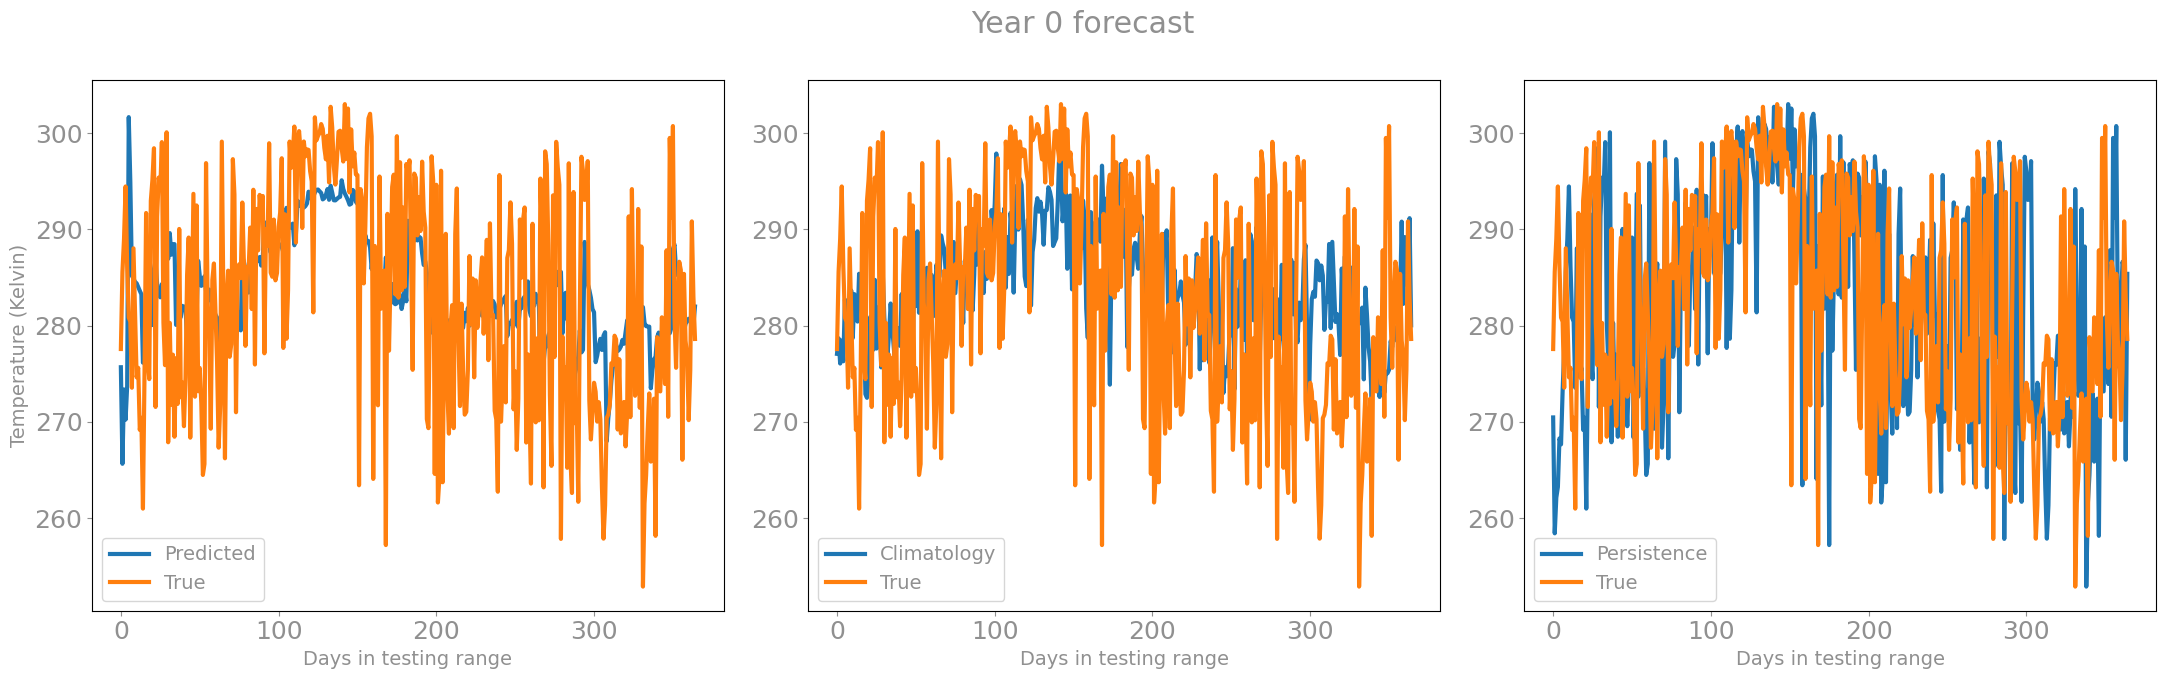

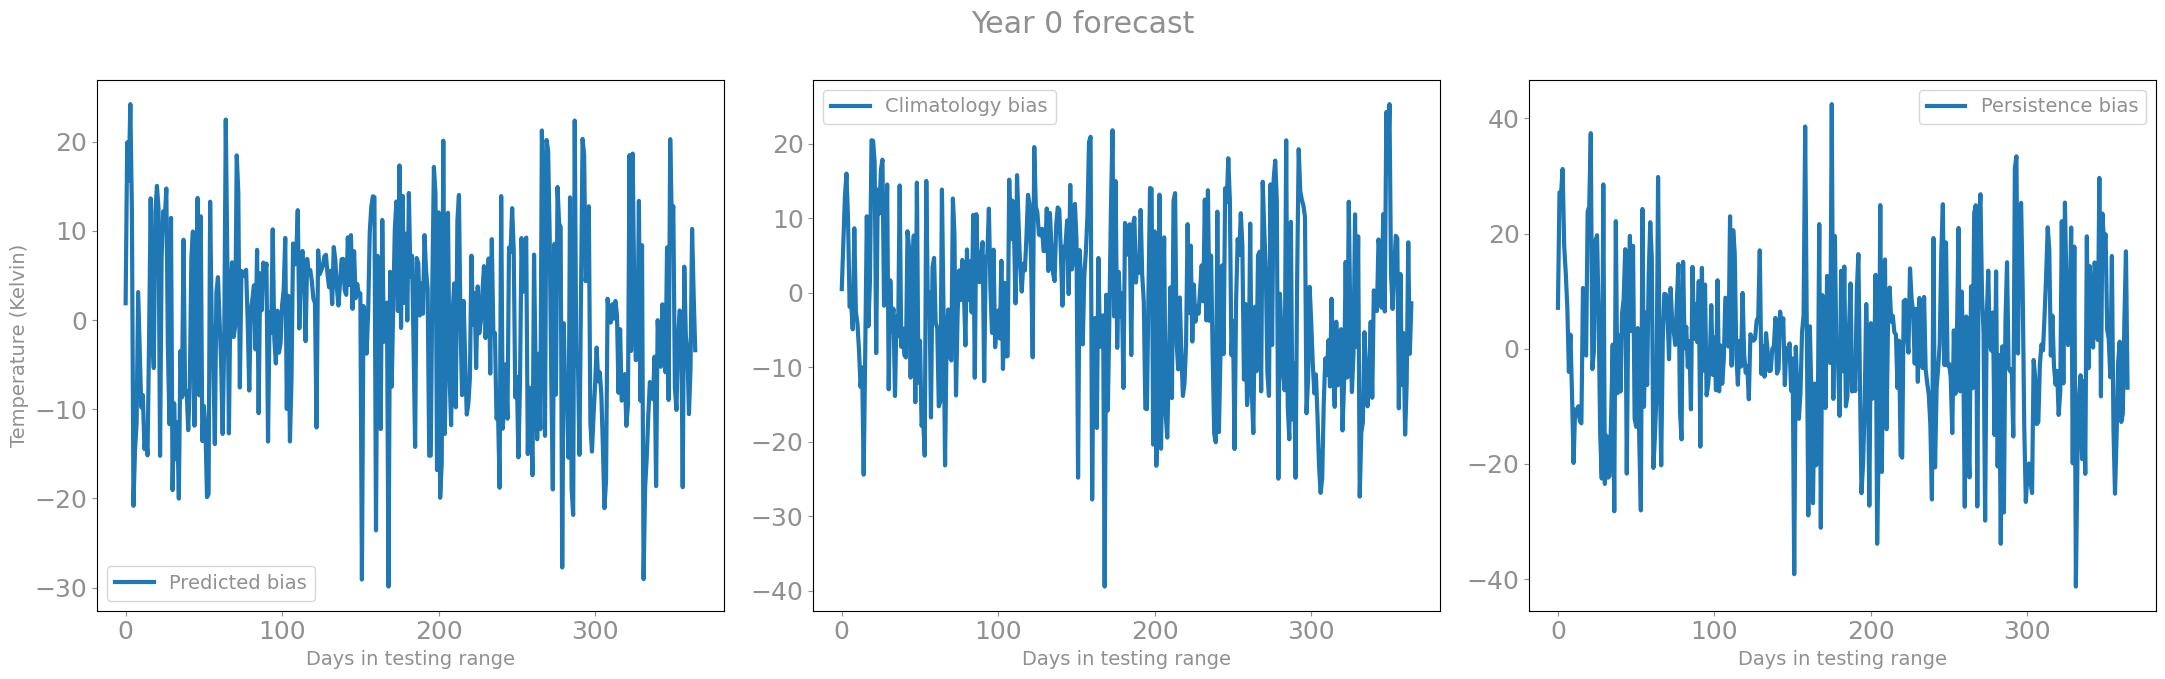

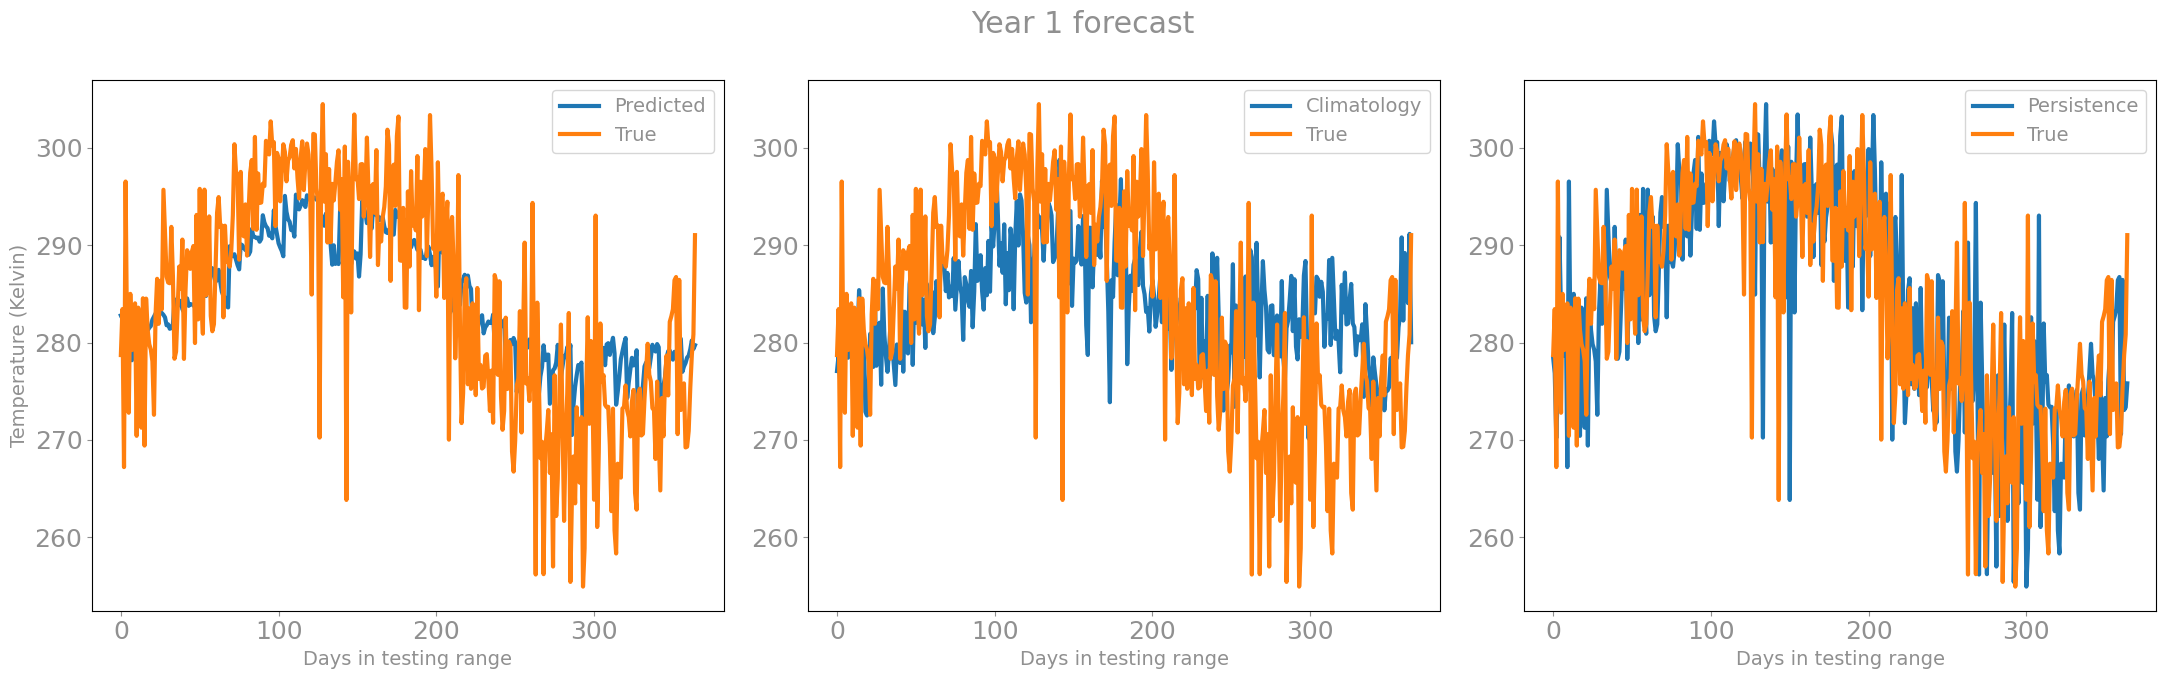

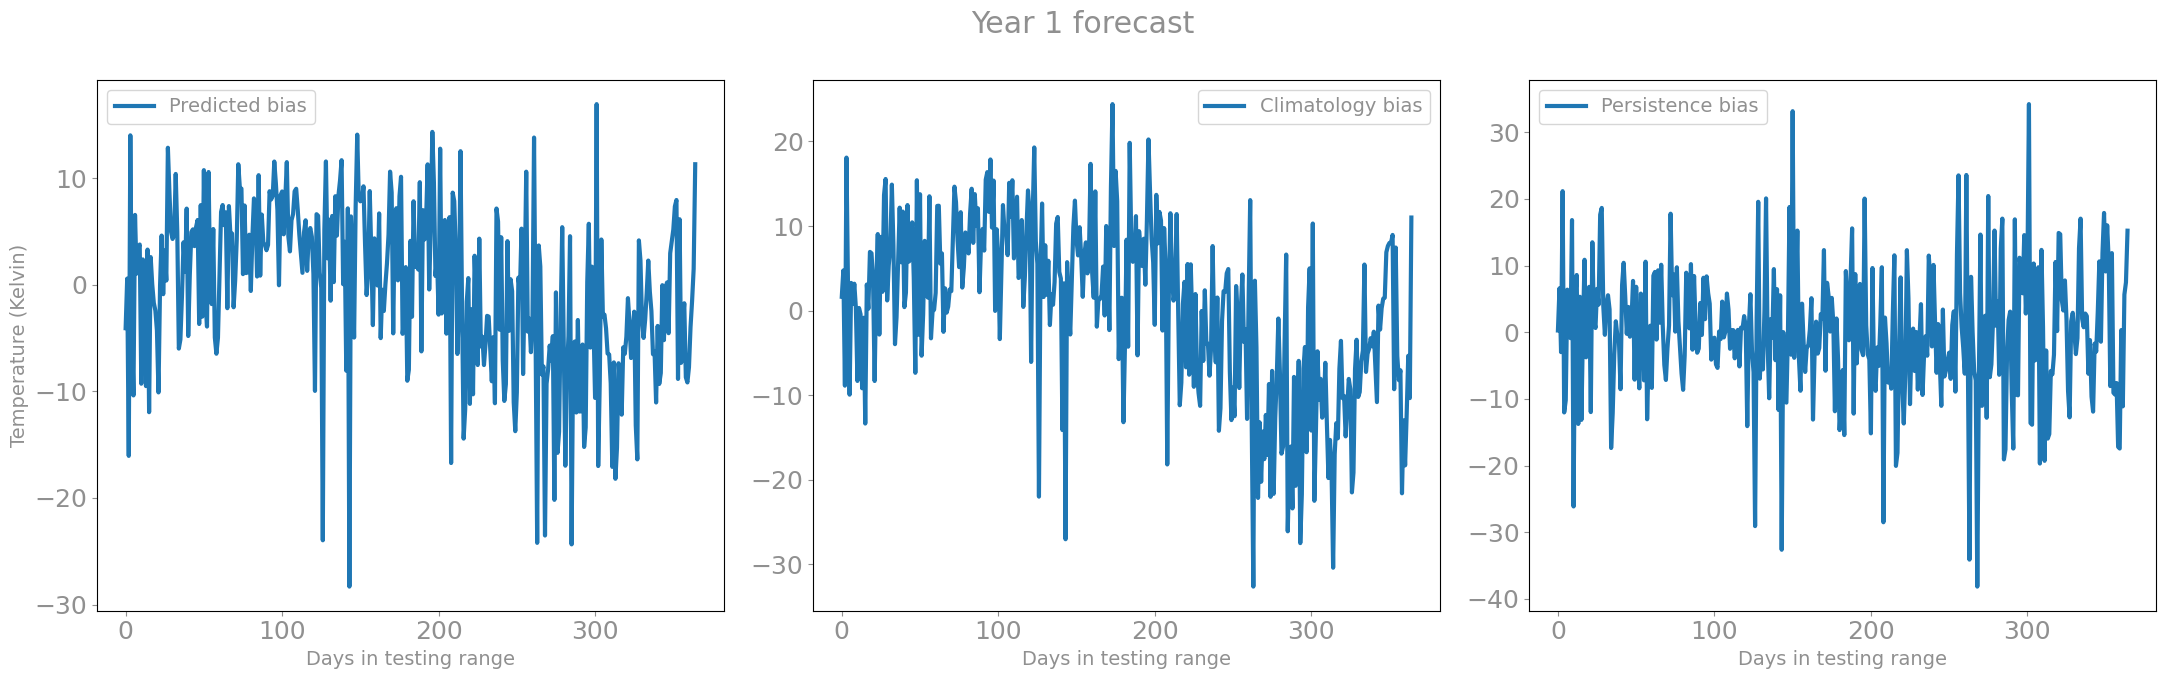

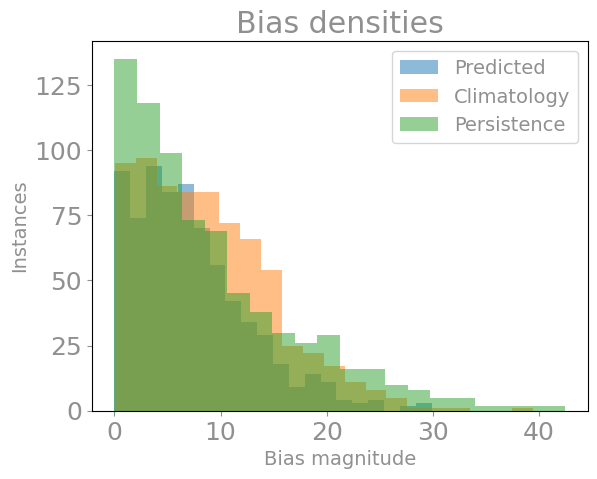

In [63]:
# Make probe of various land locations
y_loc = 220
x_loc = 400
probe_func(y_loc,x_loc,'Chicago')

In [64]:
pred_r_vals, pers_r_vals, clim_r_vals = correlation_plot(year=0,int_start=0,int_end=365)

In [67]:
pred_cos_vals, pers_cos_vals, clim_cos_vals = cosine_plot(year=0,int_start=0,int_end=365)

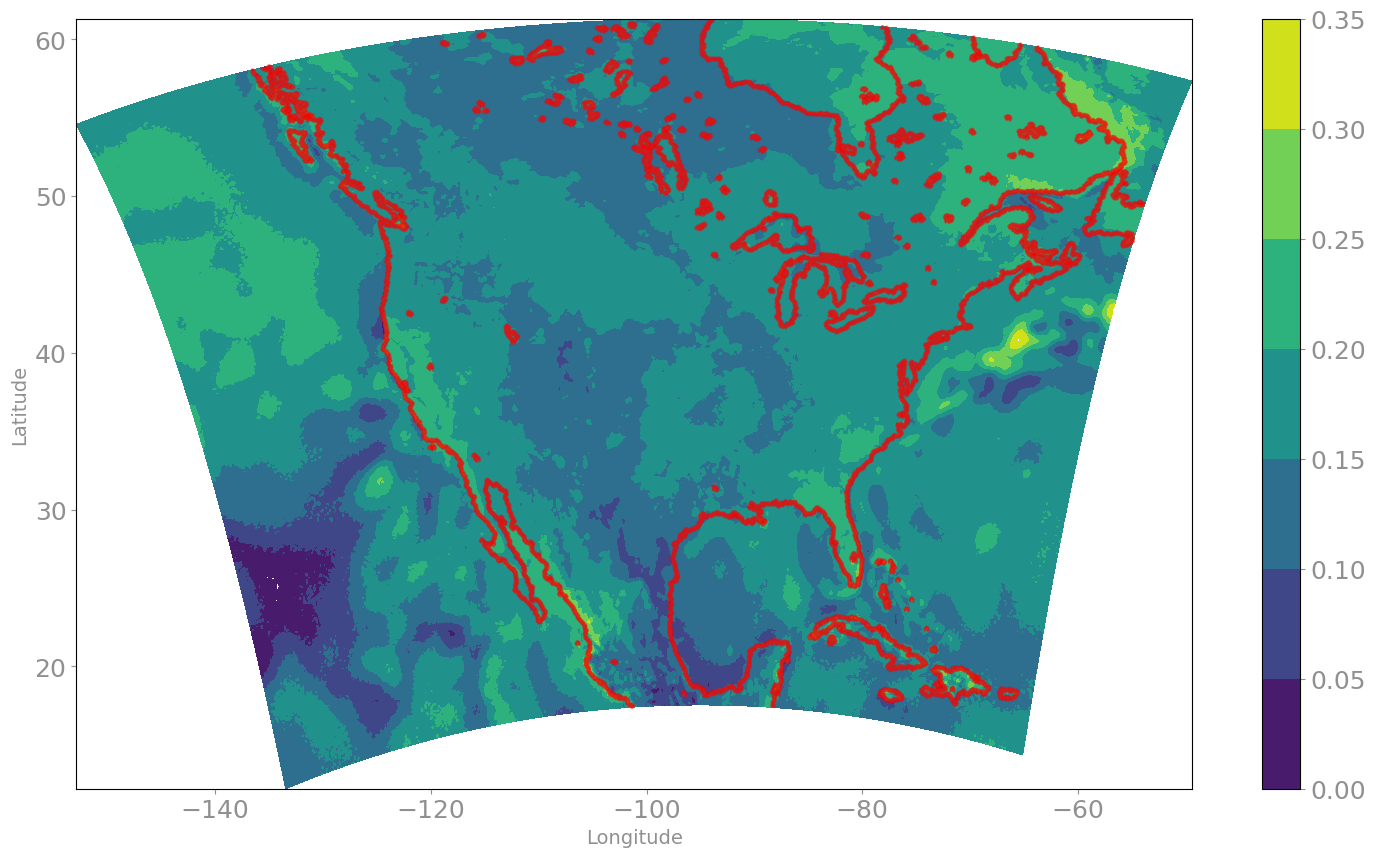

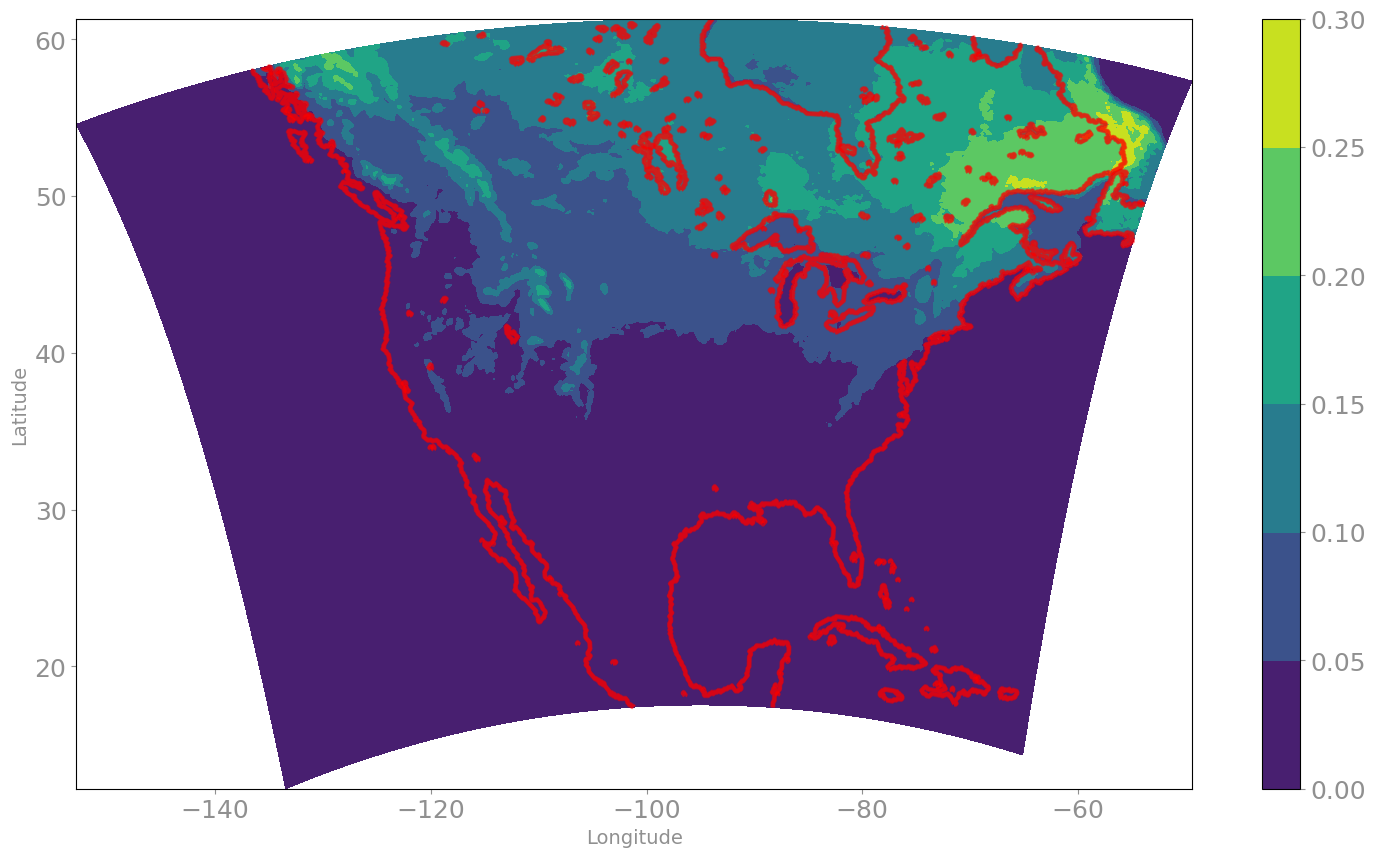

In [68]:
r_diff_vals = pred_r_vals-clim_r_vals

plt.figure(figsize=(18,10))
corr_levels = np.arange(0.0,r_diff_vals.max(),step=0.05)
plt.contourf(lons,lats,r_diff_vals,levels=corr_levels)
plt.colorbar()
plt.contour(lons,lats,mask,alpha=0.2,colors=['red'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

r_diff_vals = pred_cos_vals-clim_cos_vals

plt.figure(figsize=(18,10))
corr_levels = np.arange(0.0,r_diff_vals.max(),step=0.05)
plt.contourf(lons,lats,r_diff_vals,levels=corr_levels)
plt.colorbar()
plt.contour(lons,lats,mask,alpha=0.2,colors=['red'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

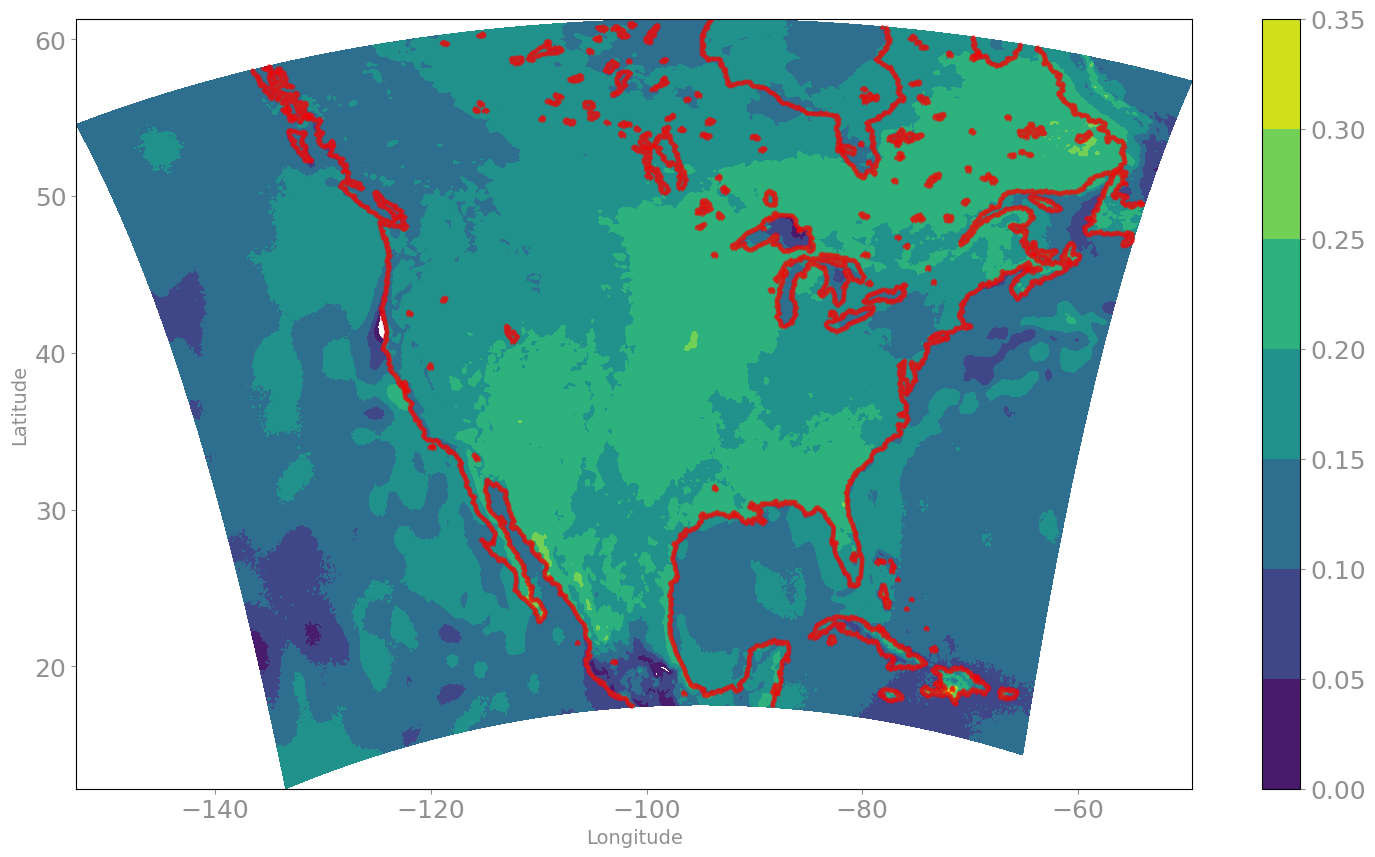

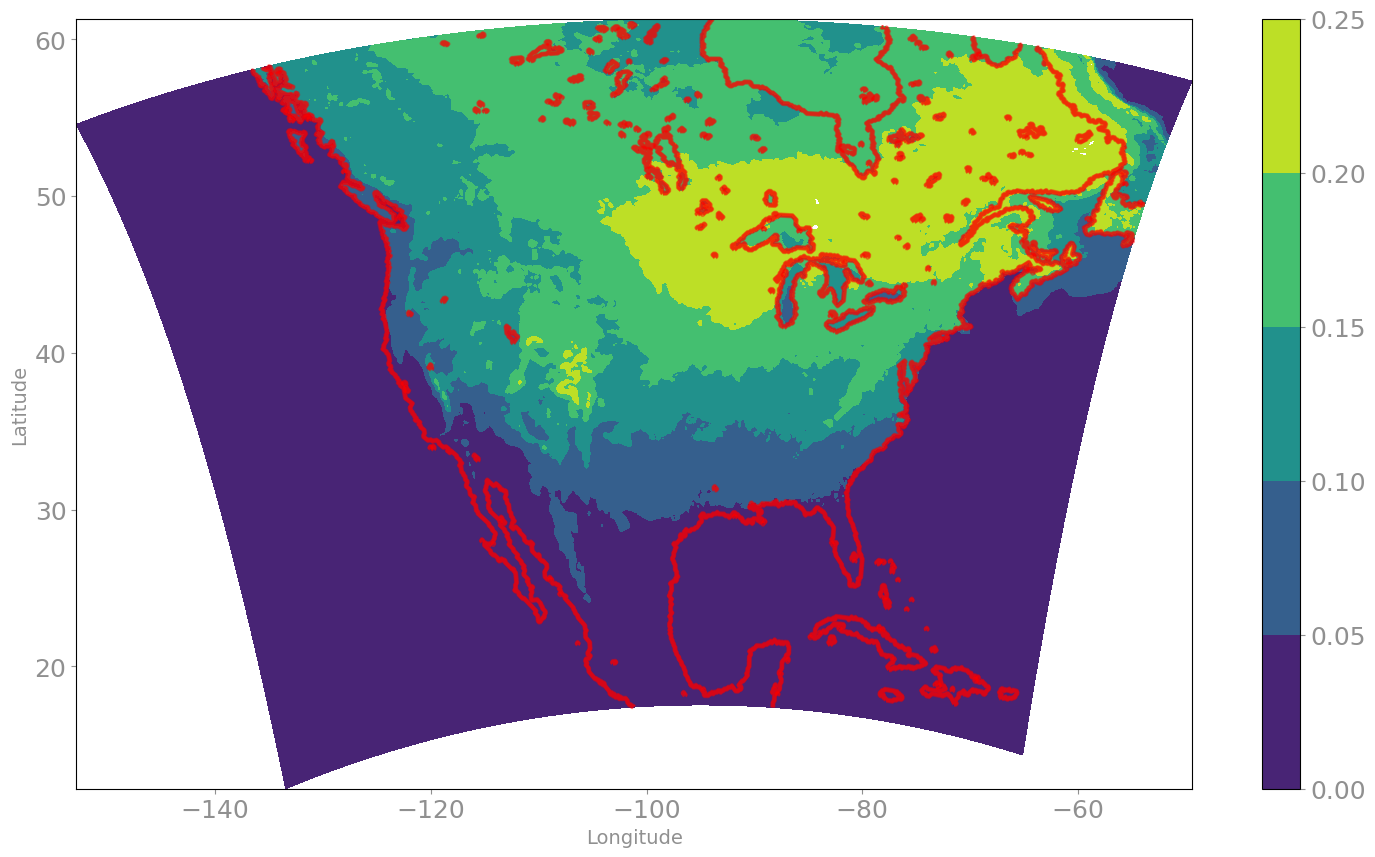

In [69]:
r_diff_vals = pred_r_vals-pers_r_vals

plt.figure(figsize=(18,10))
corr_levels = np.arange(0.0,r_diff_vals.max(),step=0.05)
plt.contourf(lons,lats,r_diff_vals,levels=corr_levels)
plt.colorbar()
plt.contour(lons,lats,mask,alpha=0.2,colors=['red'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

r_diff_vals = pred_cos_vals-pers_cos_vals

plt.figure(figsize=(18,10))
corr_levels = np.arange(0.0,r_diff_vals.max(),step=0.05)
plt.contourf(lons,lats,r_diff_vals,levels=corr_levels)
plt.colorbar()
plt.contour(lons,lats,mask,alpha=0.2,colors=['red'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()